# 02 — Neural Networks as Function Composition

Purpose: understand a neural network as repeated composition of affine maps (`xW + b`) and nonlinearities, and see why removing nonlinearities collapses depth into a single linear map.

## Learning goals
- Model a network as composed functions with explicit shapes.
- Prove-by-experiment: stacking linear layers without activations is still linear.
- Visualize how nonlinearities change decision boundaries.

## Prerequisites
- Notebook 01 (linear model intuition).
- Comfortable with matrix multiplication and shapes.
- Basic plotting.

## Key ideas
- A layer: `z = xW + b`, `a = f(z)`.
- Without `f`, multiple layers multiply into one: `(xW1 + b1)W2 + b2 = x(W1W2) + (b1W2 + b2)`.
- Nonlinearities prevent this collapse and enable non-linear boundaries.

## Minimal theory
- Linear/affine maps preserve linear separability structure.
- Nonlinearities create piecewise-linear or curved mappings that can separate complex patterns.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def relu(z):
    return np.maximum(0.0, z)

def tanh(z):
    return np.tanh(z)

def make_rings(N=600, noise=0.08, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    # Two rings in 2D
    angles = rng.uniform(0, 2*np.pi, size=(N,))
    r0 = 0.6 + rng.normal(0, noise, size=(N//2,))
    r1 = 1.2 + rng.normal(0, noise, size=(N//2,))
    a0 = angles[:N//2]
    a1 = angles[N//2:]
    x0 = np.c_[r0*np.cos(a0), r0*np.sin(a0)]
    x1 = np.c_[r1*np.cos(a1), r1*np.sin(a1)]
    x = np.vstack([x0, x1])
    y = np.vstack([np.zeros((N//2,1)), np.ones((N//2,1))])
    idx = rng.permutation(N)
    return x[idx], y[idx]

x, y = make_rings(N=700, noise=0.06, rng=rng)
print('x shape:', x.shape, 'y shape:', y.shape)

x shape: (700, 2) y shape: (700, 1)


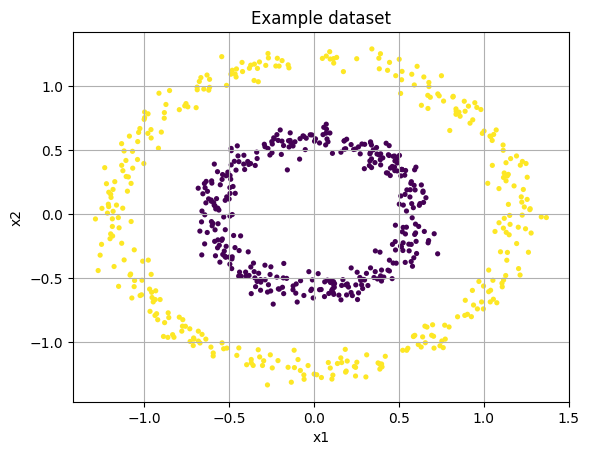

In [2]:
plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none')
plt.title("Example dataset")
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()


## Step-by-step experiments
1. Build a 2-layer *linear-only* network and show it equals a single affine map.
2. Add ReLU between layers and show the mapping is no longer equivalent to a single affine map.
3. Visualize decision regions produced by each mapping (fixed random weights).

In [65]:
# 1) Linear-only: a2 = xW1 + b1; then a3 = a2W2 + b2
D_in, H, D_out = 2, 12, 1
W1 = rng.normal(0, 1.0, size=(D_in, H))
b1 = rng.normal(0, 0.2, size=(1, H))
W2 = rng.normal(0, 1.0, size=(H, D_out))
b2 = rng.normal(0, 0.2, size=(1, D_out))

z1 = x @ W1 + b1
z2 = z1 @ W2 + b2

# Collapse into one affine map: x @ (W1W2) + (b1W2 + b2)
W_c = W1 @ W2
b_c = b1 @ W2 + b2
z_c = x @ W_c + b_c

max_abs_diff = np.max(np.abs(z2 - z_c))
print('z1 shape:', z1.shape)
print('z2 shape:', z2.shape)
print('Collapsed W_c shape:', W_c.shape, 'b_c shape:', b_c.shape)
print('Max |z2 - z_c|:', max_abs_diff)

z1 shape: (700, 12)
z2 shape: (700, 1)
Collapsed W_c shape: (2, 1) b_c shape: (1, 1)
Max |z2 - z_c|: 3.552713678800501e-15


In [66]:
from typing import Literal

# 2) Nonlinear: add ReLU
def use_activation(activation: Literal['relu', 'tanh'], z1: np.ndarray) -> np.ndarray:
    if activation == 'relu':
        return relu(z1)
    elif activation == 'tanh':
        return tanh(z1)
    raise ValueError(f"Invalid activation function: {activation}")


activation_func = 'tanh'

a1 = use_activation(activation_func, z1)
z2_after_activation = a1 @ W2 + b2

# There's no single affine map that matches ReLU composition for all x.
# We show this by fitting the best affine map (least squares) and measuring residual.
X_aug = np.c_[x, np.ones((x.shape[0], 1))]  # add bias feature
theta, *_ = np.linalg.lstsq(X_aug, z2_after_activation, rcond=None)  # (D_in+1, D_out)
z_hat = X_aug @ theta
rmse = np.sqrt(np.mean((z_hat - z2_after_activation)**2))
print(f'RMSE of best affine fit to {activation_func}-composed output:', rmse)

RMSE of best affine fit to tanh-composed output: 0.5567333839772384


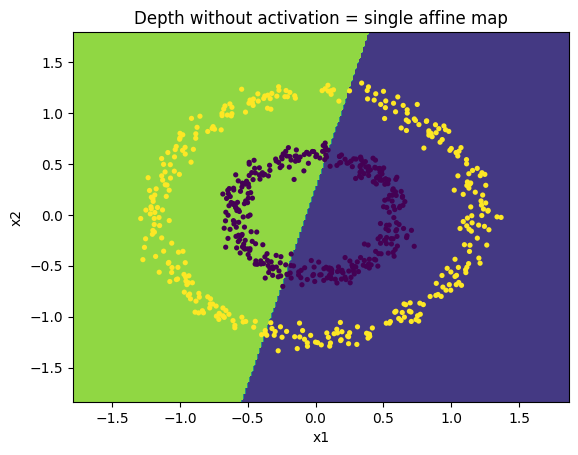

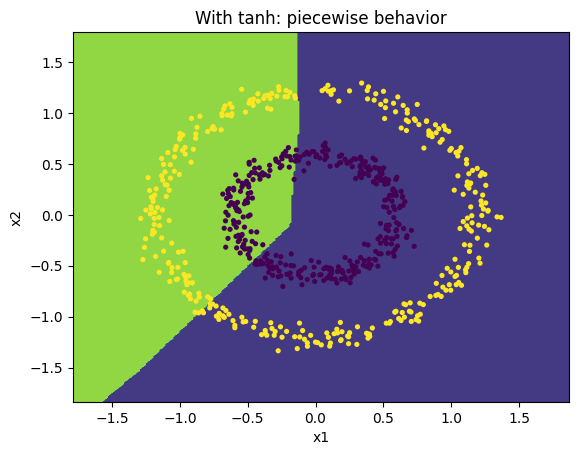

In [67]:
def plot_regions(x, y, score_fn, title):
    x1_min, x1_max = x[:,0].min()-0.5, x[:,0].max()+0.5
    x2_min, x2_max = x[:,1].min()-0.5, x[:,1].max()+0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 250), np.linspace(x2_min, x2_max, 250))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    s = score_fn(grid).reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, s > 0.0, levels=2)
    plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Plot 1: linear-only boundary (threshold at 0)
plot_regions(x, y, lambda u: (u @ W_c + b_c)[:,0], 'Depth without activation = single affine map')

# Plot 2: with ReLU boundary (threshold at 0)
plot_regions(x, y, lambda u: ((relu(u @ W1 + b1)) @ W2 + b2)[:,0], f'With {activation_func}: piecewise behavior')

## Reflection questions
1. Why do stacked affine maps collapse into one affine map?
2. What does the ReLU change in terms of geometry?
3. If you used sigmoid instead of ReLU, what would change about the regions?
4. In practice, why might deeper nets still help even if one layer could fit (optimization/regularization)?
5. What is the engineering implication of “piecewise” behavior for debugging?

## Optional extensions
1. Increase hidden width `H` and see how regions change.
2. Try `tanh` instead of ReLU and re-plot.
3. Visualize the intermediate activations `a1` as a 6D feature map using pairwise scatter plots.

## Summary
- A network is function composition: affine map → nonlinearity → affine map → ...
- Depth without activations is mathematically redundant.
- Nonlinearities prevent collapse and enable non-linear boundaries.
- Shape discipline makes these identities easy to verify.
- Visualizing regions is a fast sanity check.